In [308]:
from config import omdb_api_key, tmdb_api_key
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import itertools
import sqlite3
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import re
import json

In [4]:
#set up connection to our db and create our cursor
conn = sqlite3.connect('movies.db')
c = conn.cursor()

In [5]:
#creates initial soup using rotten tomatoes url
def create_soup(year):
    rotten_tomatoes = requests.get("https://www.rottentomatoes.com/top/bestofrt/?year=" + str(year))
    soup = BeautifulSoup(rotten_tomatoes.content, 'html.parser')
    return soup


In [6]:
#function to create a list of dictionaries containing values from rotten tomatoes page
def find_values_range(year_1, year_2):
    final_results = []
    #iterate through years in range given
    for i in range(year_1, year_2 + 1):
        #use create soup function and pass in the current year (i)
        soup = create_soup(i)
        #our data needed lies within the table class
        values = soup.find_all(class_ = 'table')
        #create list of classes that we will pull to obtain rank, year, score and reviews
        classes = ['bold', 'right hidden-xs', 'tMeterScore', 'unstyled articleLink']
        #create empty lists to store our data
        ranks = []
        names = []
        rotten_scores = []
        ratings = []
        
        #iterate through tags within the 'table' class
        for v in values:
            #for each tag in our classes list, find the tags for each class
            for c in classes:
                find = v.find_all(class_ = c)
                #based on the current c, get text and append to the proper list
                for i in find:
                    if c == 'bold':
                        rank = i.get_text()
                        ranks.append(rank)
                    if c == 'right hidden-xs':
                        rating = i.get_text()
                        #check len of the rating, we need to get rid of the first item because its not a number
                        if len(rating) <= 4:
                            ratings.append(rating)
                    if c == 'tMeterScore':
                        #strip off the crap at the end of the score
                        score = i.get_text().strip('\xa0')
                        rotten_scores.append(score)
                    if c == 'unstyled articleLink':
                        #strip off the crap at the beginning of the name
                        name = i.get_text().strip('\n            ')
                        names.append(name)
        
        #create new dict for each set of movie values
        for i in range(len(ranks)):
            new_dict = {}
            new_dict['rank'] = ranks[i]
            new_dict['name'] = names[i]
            new_dict['rotten_score'] = rotten_scores[i]
            new_dict['ratings'] = ratings[i]
            #append each dictionary to the final_results list
            final_results.append(new_dict)

    return final_results

In [159]:
#uncomment and run this cell to scrape rotten tomatoes 
#create variable in order to make list of just the movie names
#dict_ = find_values_range(2009,2018)

In [7]:
#create a list of names from the returned dict
def take_names(dictionary):
    names = []
    for i in range(len(dictionary)):
        names.append(dictionary[i]['name'])
    return names

In [8]:
#strip off the years from the names so that we can use the names to search through the api
def strip_years(dictionary):
    years = take_names(dictionary)
    stripped_names = []
    for year in years:
        year = year[:-7]
        stripped_names.append(year)
    return stripped_names
        

In [158]:
strip_years(dict_)[:10]

In [9]:
#create table for the rotten tomatoes scraped data
c.execute("""CREATE TABLE IF NOT EXISTS Rotten_Data(rank REAL, name TEXT, rotten_score NUMERIC, Num_of_Reviews INTEGER)""")

In [10]:
#create function to enter the scraped data into the db
def dynamic_data_entry(query):

    for i in query:
        c.execute("INSERT INTO Rotten_Data (Rank, Name,Rotten_Score,Num_of_Reviews) VALUES (?, ?, ?, ?)",
          (i['rank'], i['name'], i['rotten_score'], i['ratings']))

    conn.commit()

dynamic_data_entry(find_values_range(2009,2018))

In [160]:
#view db
#c.execute("""SELECT * FROM Rotten_Data""").fetchall()

In [12]:
#place db into pandas dataframe
rotten_df = pd.read_sql_query("SELECT * FROM Rotten_Data", conn)
rotten_df.head()

,rank,name,rotten_score,Num_of_Reviews
0,1.0,Up (2009),98%,290
1,2.0,The Hurt Locker (2009),97%,279
2,3.0,Star Trek (2009),94%,342
3,4.0,Anvil! The Story of Anvil (2009),98%,135
4,5.0,Afghan Star (2009),100%,60


In [13]:
imdb_top250 = requests.get("https://www.imdb.com/chart/top?ref_=nv_mv_250")
content = imdb_top250.content
soup = BeautifulSoup(content, 'html.parser')

imdb_id=[]
for i in soup.find_all(class_='titleColumn'):
    imdb_id.append(i.find('a').get('href')[7:16])

imdb_id[:5]

['tt0111161', 'tt0068646', 'tt0071562', 'tt0468569', 'tt0050083']

In [14]:
def get_movies(id_list):

    movie_list = []

    for i in id_list:
        url = 'https://api.themoviedb.org/3/movie/{}?api_key=' + str(tmdb_api_key) + '&language=en-US'.format(i)
        response = requests.get(url)
        movie_list.append(response.json())
        time.sleep(0.5)
    return movie_list

In [1]:
#uncomment and run this cell to call the TMDB api
#get_movies()

In [355]:
#create new list and use regular expressions to stip all characters within parenthesis
final_list=[]
for i in range(len(strip_years(dict_))):
    final_list.append(re.sub("[\(\[].*?[\)\]]", "", strip_years(dict_)[i]).strip())

In [15]:

def get_movies2():
    movie_list = []

    for i in final_list:
        try:
            url = ('http://www.omdbapi.com/?t={}&plot=full&apikey=' + str(omdb_api_key)).format(i)
            response = requests.get(url)
            movie_list.append(response.json())
            time.sleep(0.1)
        except:
            pass
    return movie_list

In [360]:
with open('omdb_movies', 'w') as fout:
    json.dump(get_movies2(), fout)

In [16]:
with open('omdb_movies') as data:
    d = json.load(data)
rt_df = pd.DataFrame(d)


In [17]:
final_RT_DF = pd.merge(rt_df, rotten_df, right_index = True, left_index = True)


In [18]:
final_RT_DF = final_RT_DF.dropna(subset=['imdbID'])
final_RT_DF = final_RT_DF.set_index('imdbID')


In [19]:
final_RT_DF = final_RT_DF.drop(columns = ['Type', 'totalSeasons', 'Response', 'Error', 'name', 'DVD', 'Plot', 'Poster'])

In [20]:
final_RT_DF = final_RT_DF.drop(columns = ['Website'])

In [21]:
final_RT_DF = final_RT_DF.drop(columns = ['Released', 'rank'])

In [22]:
final_RT_DF = final_RT_DF.drop(columns = ['Ratings'])

In [23]:
final_RT_DF.columns

Index(['Actors', 'Awards', 'BoxOffice', 'Country', 'Director', 'Genre',
       'Language', 'Metascore', 'Production', 'Rated', 'Runtime', 'Title',
       'Writer', 'Year', 'imdbRating', 'imdbVotes', 'rotten_score',
       'Num_of_Reviews'],
      dtype='object')

In [24]:
final_RT_DF = final_RT_DF[['Title', 'Year', 'BoxOffice', 'Metascore', 'rotten_score', 'Num_of_Reviews', 'imdbRating',
                          'imdbVotes', 'Country', 'Director', 'Actors', 'Genre', 'Language', 'Production', 'Rated', 
                          'Runtime', 'Writer', 'Awards']]


In [25]:
final_RT_DF['rotten_score'] = final_RT_DF['rotten_score'].str.replace('%', '')
final_RT_DF['rotten_score'] = final_RT_DF['rotten_score'].astype(int)

In [26]:
final_RT_DF['BoxOffice'] = final_RT_DF['BoxOffice'].replace('N/A','0')
final_RT_DF['BoxOffice'] = final_RT_DF['BoxOffice'].replace('NaN','0')

In [27]:
final_RT_DF['Metascore'] = final_RT_DF['Metascore'].replace('N/A','0')
final_RT_DF['imdbRating'] = final_RT_DF['imdbRating'].replace('N/A','0')
final_RT_DF['imdbVotes'] = final_RT_DF['imdbVotes'].str.replace(',', '')
final_RT_DF['imdbVotes'] = final_RT_DF['imdbVotes'].replace('N/A', '0')

In [28]:
final_RT_DF['BoxOffice'] = final_RT_DF['BoxOffice'].str.replace('$', '')
final_RT_DF['BoxOffice'] = final_RT_DF['BoxOffice'].str.replace(',', '')
#final_RT_DF['BoxOffice'] = final_RT_DF['BoxOffice'].astype(int)
final_RT_DF['Metascore'] = final_RT_DF['Metascore'].astype(int)
final_RT_DF['Num_of_Reviews'] = final_RT_DF['Num_of_Reviews'].astype(int)
final_RT_DF['imdbRating'] = final_RT_DF['imdbRating'].astype(float)
final_RT_DF['imdbVotes'] = final_RT_DF['imdbVotes'].astype(int)

In [161]:
imdb_id_list = list(final_RT_DF.index)
#check length of list
len(imdb_id_list)

966

In [157]:
#save imdb movies to json file after api requests
with open('imdb_movies', 'w') as fout:
    json.dump(get_movies(imdb_id_list), fout)


In [162]:
#open json file and load data into dataframe
with open('imdb_movies') as data_2:
    d_2 = json.load(data_2)
imdb_df = pd.DataFrame(d_2)


Data Cleaning

In [31]:
imdb_df=imdb_df.drop(columns=['adult','backdrop_path','genres','homepage','id','original_language','original_title','spoken_languages','status','status_code','status_message','tagline','video','vote_average','vote_count'])
imdb_df=imdb_df.drop(columns=['overview','popularity','poster_path'])
imdb_df=imdb_df.drop(columns=['production_companies','production_countries'])

final_RT_DF=final_RT_DF.drop(columns=['BoxOffice','Runtime'])

In [32]:
#merge data frames to create final usable dataframe called movies_df
movies_df = pd.merge(final_RT_DF, imdb_df, left_on = 'imdbID', right_on = 'imdb_id', how = 'right')

In [33]:
movies_df = movies_df.drop(columns = ['Year', 'title'])

In [34]:
movies_df.set_index('imdb_id')

,Title,Metascore,rotten_score,Num_of_Reviews,imdbRating,imdbVotes,Country,Director,Actors,Genre,Language,Production,Rated,Writer,Awards,belongs_to_collection,budget,release_date,revenue,runtime
imdb_id,,,,,,,,,,,,,,,,,,,,
tt1049413,Up,88.0,98.0,290.0,8.3,832494.0,USA,"Pete Docter, Bob Peterson(co-director)","Edward Asner, Christopher Plummer, Jordan Naga...","Animation, Adventure, Comedy, Family",English,Walt Disney Pictures,PG,"Pete Docter (story by), Bob Peterson (story by...",Won 2 Oscars. Another 74 wins & 81 nominations.,None,175000000.0,2009-05-28,735099082.0,96.0
tt0887912,The Hurt Locker,94.0,97.0,279.0,7.6,388856.0,USA,Kathryn Bigelow,"Jeremy Renner, Anthony Mackie, Brian Geraghty,...","Drama, Thriller, War","English, Arabic",Summit Entertainment,R,Mark Boal,Won 6 Oscars. Another 117 wins & 126 nominations.,None,15000000.0,2008-10-10,42000000.0,131.0
tt0796366,Star Trek,82.0,94.0,342.0,8.0,552796.0,"USA, Germany",J.J. Abrams,"Chris Pine, Zachary Quinto, Leonard Nimoy, Eri...","Action, Adventure, Sci-Fi",English,IMAX,PG-13,"Roberto Orci, Alex Kurtzman, Gene Roddenberry ...",Won 1 Oscar. Another 23 wins & 92 nominations.,"{'id': 115575, 'name': 'Star Trek: Alternate R...",150000000.0,2009-05-06,385680446.0,127.0
tt1334510,Afghan Star,78.0,100.0,60.0,7.3,887.0,UK,Havana Marking,"Habib Amiri, Setara Hussainzada, Rafi Naabzada...","Documentary, Music","English, Pushto, Dari",Zeitgeist Films,UNRATED,N/A,2 wins & 3 nominations.,None,0.0,2009-06-26,101543.0,87.0
tt1174732,An Education,85.0,95.0,189.0,7.3,122460.0,"UK, USA",Lone Scherfig,"Carey Mulligan, Olivia Williams, Alfred Molina...",Drama,"English, French",Sony Classics,PG-13,"Lynn Barber (memoir), Nick Hornby (screenplay)",Nominated for 3 Oscars. Another 35 wins & 91 n...,None,7500000.0,2009-10-29,26096852.0,100.0
tt1127180,Drag Me to Hell,83.0,92.0,262.0,6.6,175937.0,USA,Sam Raimi,"Alison Lohman, Justin Long, Lorna Raver, Dilee...","Horror, Thriller","English, Spanish, Hungarian, Czech",Universal Pictures,PG-13,"Sam Raimi, Ivan Raimi",7 wins & 22 nominations.,None,30000000.0,2009-03-15,90810892.0,99.0
tt1136608,District 9,81.0,90.0,308.0,7.9,598691.0,"South Africa, USA, New Zealand, Canada",Neill Blomkamp,"Sharlto Copley, Jason Cope, Nathalie Boltt, Sy...","Action, Sci-Fi, Thriller","English, Nyanja, Afrikaans, Zulu, Xhosa, South...",Sony Pictures/Screen Gems,R,"Neill Blomkamp, Terri Tatchell",Nominated for 4 Oscars. Another 30 wins & 110 ...,None,30000000.0,2009-08-05,210819611.0,112.0
tt1193138,Up in the Air,83.0,91.0,278.0,7.4,298600.0,USA,Jason Reitman,"George Clooney, Vera Farmiga, Anna Kendrick, J...","Drama, Romance",English,Paramount Pictures,R,"Walter Kirn (novel), Jason Reitman (screenplay...",Nominated for 6 Oscars. Another 76 wins & 158 ...,None,25000000.0,2009-09-05,163670000.0,110.0
tt0432283,Fantastic Mr. Fox,83.0,92.0,233.0,7.9,174744.0,USA,Wes Anderson,"George Clooney, Meryl Streep, Jason Schwartzma...","Animation, Adventure, Comedy, Crime, Drama, Fa...","English, French",20th Century Fox,PG,"Roald Dahl (novel), Wes Anderson (screenplay),...",Nominated for 2 Oscars. Another 32 wins & 60 n...,None,40000000.0,2009-10-23,46471023.0,87.0


In [35]:
#rearrange columns
movies_df = movies_df[['Title', 'release_date', 'budget', 'revenue', 'runtime', 'Genre', 'Metascore', 'rotten_score', 'Num_of_Reviews', 'imdbRating',
                          'imdbVotes', 'Country', 'Director', 'Actors', 'Language', 'Production', 'Rated', 
                           'Writer', 'Awards']]


In [317]:
movies_df

,Title,release_date,budget,revenue,runtime,Genre,Metascore,rotten_score,Num_of_Reviews,imdbRating,...,Language,Production,Rated,Writer,Awards,release_year,release_month,budget_in_millions,revenue_in_millions,profit_in_millions
0,Up,2009-05-28,175000000.0,735099082.0,96.0,"Animation, Adventure, Comedy, Family",88.0,98.0,290.0,8.3,...,English,Walt Disney Pictures,PG,"Pete Docter (story by), Bob Peterson (story by...",Won 2 Oscars. Another 74 wins & 81 nominations.,2009,5,175.000000,735.099082,560.099082
1,The Hurt Locker,2008-10-10,15000000.0,42000000.0,131.0,"Drama, Thriller, War",94.0,97.0,279.0,7.6,...,"English, Arabic",Summit Entertainment,R,Mark Boal,Won 6 Oscars. Another 117 wins & 126 nominations.,2008,10,15.000000,42.000000,27.000000
2,Star Trek,2009-05-06,150000000.0,385680446.0,127.0,"Action, Adventure, Sci-Fi",82.0,94.0,342.0,8.0,...,English,IMAX,PG-13,"Roberto Orci, Alex Kurtzman, Gene Roddenberry ...",Won 1 Oscar. Another 23 wins & 92 nominations.,2009,5,150.000000,385.680446,235.680446
3,Afghan Star,2009-06-26,NaN,101543.0,87.0,"Documentary, Music",78.0,100.0,60.0,7.3,...,"English, Pushto, Dari",Zeitgeist Films,UNRATED,N/A,2 wins & 3 nominations.,2009,6,NaN,0.101543,NaN
4,An Education,2009-10-29,7500000.0,26096852.0,100.0,Drama,85.0,95.0,189.0,7.3,...,"English, French",Sony Classics,PG-13,"Lynn Barber (memoir), Nick Hornby (screenplay)",Nominated for 3 Oscars. Another 35 wins & 91 n...,2009,10,7.500000,26.096852,18.596852
5,Drag Me to Hell,2009-03-15,30000000.0,90810892.0,99.0,"Horror, Thriller",83.0,92.0,262.0,6.6,...,"English, Spanish, Hungarian, Czech",Universal Pictures,PG-13,"Sam Raimi, Ivan Raimi",7 wins & 22 nominations.,2009,3,30.000000,90.810892,60.810892
6,District 9,2009-08-05,30000000.0,210819611.0,112.0,"Action, Sci-Fi, Thriller",81.0,90.0,308.0,7.9,...,"English, Nyanja, Afrikaans, Zulu, Xhosa, South...",Sony Pictures/Screen Gems,R,"Neill Blomkamp, Terri Tatchell",Nominated for 4 Oscars. Another 30 wins & 110 ...,2009,8,30.000000,210.819611,180.819611
7,Up in the Air,2009-09-05,25000000.0,163670000.0,110.0,"Drama, Romance",83.0,91.0,278.0,7.4,...,English,Paramount Pictures,R,"Walter Kirn (novel), Jason Reitman (screenplay...",Nominated for 6 Oscars. Another 76 wins & 158 ...,2009,9,25.000000,163.670000,138.670000
8,Fantastic Mr. Fox,2009-10-23,40000000.0,46471023.0,87.0,"Animation, Adventure, Comedy, Crime, Drama, Fa...",83.0,92.0,233.0,7.9,...,"English, French",20th Century Fox,PG,"Roald Dahl (novel), Wes Anderson (screenplay),...",Nominated for 2 Oscars. Another 32 wins & 60 n...,2009,10,40.000000,46.471023,6.471023
9,In the Loop,2009-01-22,NaN,6149791.0,106.0,Comedy,83.0,94.0,172.0,7.5,...,English,IFC,Not Rated,"Jesse Armstrong (screenplay), Simon Blackwell ...",Nominated for 1 Oscar. Another 16 wins & 41 no...,2009,1,NaN,6.149791,NaN


In [163]:
#create new columns for year of release and month of release respectively
movies_df.release_date = pd.to_datetime(movies_df['release_date'])
# To answer the last question, we'll have to extract the release year from every release date
movies_df['release_year'] = movies_df['release_date'].dt.year
movies_df['release_month'] = movies_df['release_date'].dt.month


In [38]:
#drop duplicate Title column
movies_df = movies_df.dropna(subset=['Title'])

In [39]:
#change types of columns to integers
change_cols=['release_year', 'release_month']
#changing data type
movies_df[change_cols]=movies_df[change_cols].applymap(np.int64)
movies_df.dtypes

Title                     object
release_date      datetime64[ns]
budget                   float64
revenue                  float64
runtime                  float64
Genre                     object
Metascore                float64
rotten_score             float64
Num_of_Reviews           float64
imdbRating               float64
imdbVotes                float64
Country                   object
Director                  object
Actors                    object
Language                  object
Production                object
Rated                     object
Writer                    object
Awards                    object
release_year               int64
release_month              int64
dtype: object

In [40]:
#replace all 0 values with NaN's
cols = ['Metascore', 'rotten_score', 'imdbRating', 'budget', 'revenue']
movies_df[cols] = movies_df[cols].replace(0, np.nan)

In [ ]:
#create columns for profit and alter budget & revenue columns 

In [93]:
movies_df['profit_in_millions'] = (movies_df['revenue'] - movies_df['budget'])/1000000

In [90]:
movies_df['budget_in_millions'] = movies_df['budget']/1000000

In [91]:
movies_df['revenue_in_millions'] = movies_df['revenue']/1000000

In [86]:
#drop columns that were no longer usable
movies_df = movies_df.drop(columns=['profit', 'profit (in millions)'])

In [94]:
movies_df = movies_df.drop(columns = ['profit_in_millions)'])

In [167]:
group_months = movies_df.groupby('release_month').mean()


Text(0, 0.5, 'Revenue (in millions)')

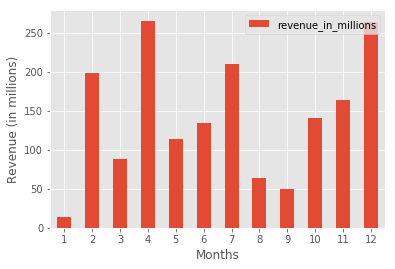

In [314]:
profit_by_month = group_months.plot.bar(y='revenue_in_millions', rot=0)
profit_by_month.set_xlabel('Months')
profit_by_month.set_ylabel('Revenue (in millions)')


In [144]:
#we only want to focus on the main ratings G, PG, PG-13, R
ratings = ['G', 'PG', 'PG-13', 'R']
#function to find mean profits for each group of ratings
def find_means_of_ratings(ratings):
    means = []
    for i in ratings:
        locate_list = movies_df.loc[(movies_df['Rated'] == i)]
        find = locate_list['profit_in_millions'].mean()
        means.append(find)
    return means


In [323]:
#find counts of each group of ratings
def find_counts_of_ratings(ratings):
    counts = []
    for i in ratings:
        locate_list = movies_df.loc[(movies_df['Rated'] == i)]
        find = locate_list['profit_in_millions'].count()
        counts.append(find)
    return counts


[5, 52, 137, 202]

In [145]:
#assign to variable so we can graph it
ratings_with_means = find_means_of_ratings(ratings)

Text(0.5, 1.0, 'Average Profit by Rating Type')

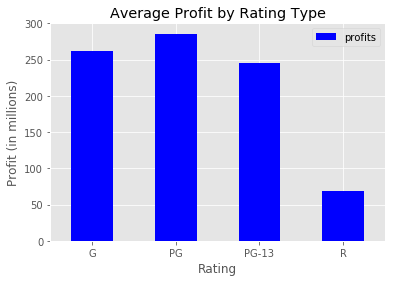

In [355]:
#new dataframe based on subset of data for ratings and profits
ratings_df = pd.DataFrame({'profits': ratings_with_means, 'count': find_counts_of_ratings(ratings)},index =ratings)


ratings_plot = ratings_df.plot.bar(y= ['profits'], rot=0, color=['blue', 'red', 'green', 'black'])
ratings_plot.set_xlabel('Rating')
ratings_plot.set_ylabel('Profit (in millions)')
plt.title('Average Profit by Rating Type')

Text(0.5, 1.0, 'Percentage of Movies Made by Rating Type')

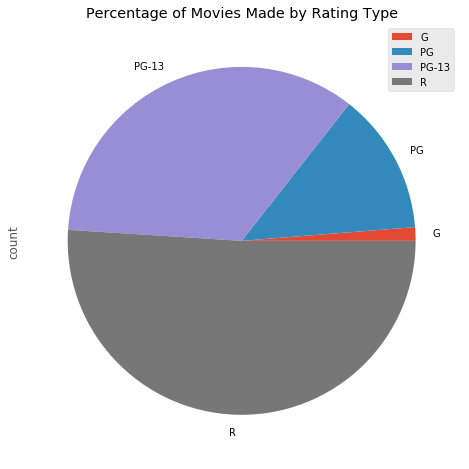

In [357]:
ratings_df.plot.pie(y='count', figsize = (8,8))
plt.title('Percentage of Movies Made by Rating Type')

In [259]:
avg_scores=movies_df[['Title','Metascore','rotten_score','release_year' ]].groupby('release_year').agg(np.mean)
avg_scores=avg_scores.iloc[20:-1]

Text(0, 0.5, 'Score Out of 100')

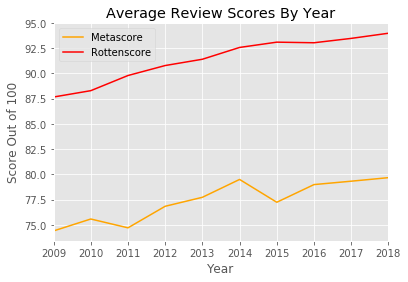

In [310]:
plt.style.use('ggplot')
fig=plt.figure();
ax1 = avg_scores.Metascore.plot(y='Metascore',color='orange')
ax2 = avg_scores.rotten_score.plot(y='Rotten_score',color='r')
ax1.plot
ax2.plot
plt.title('Average Review Scores By Year')
plt.legend(['Metascore','Rottenscore'])
plt.xlabel('Year')
plt.ylabel('Score Out of 100')

In [180]:

top_metascores = movies_df.loc[(movies_df['Metascore'] >= 90)].sort_values(by=['Metascore'], ascending=False)
top_rotten_scores = movies_df.loc[(movies_df['rotten_score'] >= 90)].sort_values(by=['rotten_score'], ascending=False)

In [303]:
#create subset of dataframe that contains movies where Metascore and rotten_score are >= 90
#then groupby the year and find the mean of each column
top_scores = movies_df.loc[(movies_df['Metascore'] >= 90) & (movies_df['rotten_score'] >= 90)].sort_values(by=['profit_in_millions'], ascending=False)
top_scores = top_scores.groupby(by='release_year').mean()
means_top_scores = top_scores.iloc[3:-1]

In [332]:
#means_top_scores.plot(y=['budget_in_millions', 'profit_in_millions'], kind="bar")

In [304]:


means_top_rotten_scores = top_rotten_scores.groupby(by='release_year').mean()
means_top_rotten_scores = means_top_rotten_scores.iloc[17:-1]
means_top_metascores = top_metascores.groupby(by='release_year').mean()
means_top_metascores = means_top_metascores.iloc[3:-1]
# means_top_metascores = top_metascores.groupby(by='release_year').max()

In [305]:
means_top_metascores

,budget,revenue,runtime,Metascore,rotten_score,Num_of_Reviews,imdbRating,imdbVotes,release_month,budget_in_millions,revenue_in_millions,profit_in_millions
release_year,,,,,,,,,,,,
2010,8.066667e+07,4.352405e+08,103.750000,92.000000,96.750000,205.500000,7.700000,340661.250000,8.000000,80.666667,435.240507,354.573840
2011,5.000000e+05,2.442617e+07,96.000000,93.000000,98.666667,104.333333,7.866667,66268.333333,7.000000,0.500000,24.426169,23.926169
2012,1.663333e+07,5.437001e+07,121.600000,92.200000,93.400000,179.400000,7.740000,75745.200000,8.800000,16.633333,54.370015,37.736681
2013,2.916561e+07,1.801894e+08,112.142857,92.857143,94.571429,264.857143,7.685714,346946.857143,9.714286,29.165611,180.189415,151.023804
2014,4.000000e+06,1.111202e+07,128.000000,93.333333,97.666667,159.166667,7.583333,67876.000000,8.500000,4.000000,11.112021,20.372910
2015,8.650000e+07,2.285193e+08,110.833333,92.666667,96.333333,300.333333,7.700000,302129.333333,7.833333,86.500000,228.519279,245.148257
2016,1.160000e+07,1.469155e+08,110.666667,92.555556,96.000000,211.333333,7.577778,108677.222222,8.111111,11.600000,146.915523,134.915523
2017,2.533333e+07,1.013275e+08,107.875000,93.000000,95.875000,274.625000,7.687500,119137.625000,7.875000,25.333333,101.327470,92.697218
2018,1.050850e+07,3.025240e+07,117.142857,91.285714,96.000000,230.142857,7.685714,42391.142857,5.428571,10.508500,30.252401,26.811965


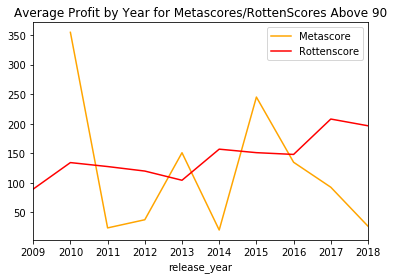

In [306]:
fig=plt.figure();
ax1 = means_top_metascores.profit_in_millions.plot(y='profit_in_millions',color='orange')
ax2 = means_top_rotten_scores.profit_in_millions.plot(y='profit_in_millions',color='r')

ax1.plot
ax2.plot
plt.title('Average Profit by Year for Metascores/RottenScores Above 90')
plt.legend(['Metascore','Rottenscore'])

# means_top_rotten_scores['profit_in_millions'].plot(kind = 'bar')
# means_top_metascores['profit_in_millions'].plot()
#means_top_rotten_scores.plot('Metascore','revenue_in_millions', kind = 'scatter')

In [1]:
#create soup function for box office mojo data
def create_soup1(year):
    boxoffice_mojo = requests.get("https://www.boxofficemojo.com/yearly/chart/?yr={}&p=.htm".format(year))
    soup=BeautifulSoup(boxoffice_mojo.content, 'html.parser')
    return soup

In [27]:
#function to scrape box office mojo data
#returns gross revenue, number of theatres, rank, studio, title and year of each movie scraped
final_movies=[]
def find_movies_by_year(year_1, year_2):  
    final_results = []
    for year in range(year_1, year_2 + 1):
        sample_soup=create_soup1(year).find_all('table', attrs={'cellspacing': '1'})[0]
        box_office_list=[]
        
        for movie in sample_soup.find_all('tr')[2:52]:
            temp_list=[]
            for i in movie.find_all('td'):   
                if movie.find_all('td'):
                    temp_list.append(i.get_text())
                    box_office_list.append(temp_list)

        box_office_list=list(box_office_list for box_office_list,_ in itertools.groupby(box_office_list))

        counter=0
        for box in box_office_list:
            movie_dict={}
            movie_dict["rank"]=box_office_list[counter][0]
            movie_dict["title"]=box_office_list[counter][1]
            movie_dict['year']=year
            movie_dict["studio"]=box_office_list[counter][2]
            movie_dict["gross"]=box_office_list[counter][3]
            movie_dict["num_of_theaters"]=box_office_list[counter][4]
            counter+=1
            final_movies.append(movie_dict)

    return final_movies

In [28]:
#place our scraped data from 2009-2018 into a pandas dataframe
boxoffice_df = pd.DataFrame(find_movies_by_year(2009,2018))


In [29]:
boxoffice_df.head()

,gross,num_of_theaters,rank,studio,title,year
0,"$749,766,139","3,461",1,Fox,Avatar,2009
1,"$402,111,870","4,293",2,P/DW,Transformers: Revenge of the Fallen,2009
2,"$301,959,197","4,455",3,WB,Harry Potter and the Half-Blood Prince,2009
3,"$296,623,634","4,124",4,Sum.,The Twilight Saga: New Moon,2009
4,"$293,004,164","3,886",5,BV,Up,2009
